In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier as XGBC
import sklearn.utils 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, classification_report

pd.set_option('display.max_columns', 50)

In [2]:
cleaned_data = pd.read_csv('cleaned_got_for_ml.csv', index_col=0)

In [3]:
cleaned_data.head()

,male,book1,book4,isAliveHeir,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive,inHouseOfAllegnc,mother_Alicent Hightower,mother_Alyssa Targaryen,mother_Alyssa Velaryon,mother_Betha Blackwood,mother_Cassana Estermont,mother_Catelyn Stark,mother_Cersei Lannister,mother_Daenaera Velaryon,mother_Dyanna Dayne,mother_Lady of House Sunderly,mother_Mariah Martell,mother_Naerys Targaryen,mother_Rhaenyra Targaryen,mother_Rhaenys Targaryen,...,father_Viserys I Targaryen,father_unknown,heir_Aegon IV Targaryen,heir_Aegon Targaryen,heir_Aemon Targaryen,heir_Aenys Targaryen,heir_Aerys II Targaryen,heir_Arlan V Durrandon,heir_Baelor 'Breakspear' Targaryen,heir_Baelor I Targaryen,heir_Bran Stark,heir_Daeron I Targaryen,heir_Daeron II Targaryen,heir_Duncan Targaryen,heir_Durran the Devout,heir_Halleck Hoare,heir_Jaehaerys Targaryen,heir_Myrcella Baratheon,heir_Rhaegar Targaryen,heir_Rhaegel Targaryen,heir_Rhaenyra Targaryen,heir_Shireen Baratheon,heir_Theon Greyjoy,heir_Tommen Baratheon,heir_unknown
0,1,0,0,0.0,37.0,11,1,1,0.605351,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,-1.0,97.0,1,1,1,0.896321,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,1,-1.0,37.0,0,0,0,0.267559,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,-1.0,23.0,0,0,0,0.183946,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,1,-1.0,29.0,0,0,0,0.043478,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [4]:
# Under Sampling Data
dead = cleaned_data[cleaned_data['isAlive'] == 0]
alive = cleaned_data[cleaned_data['isAlive'] == 1].sample(500, random_state=42)
und_samp_df = pd.concat([dead, alive])

und_samp_df = sklearn.utils.shuffle(und_samp_df, random_state=42)
und_samp_df = und_samp_df.reset_index(drop=True)

# Scaling our cleaned_data
scaler = StandardScaler()
norm_df = scaler.fit_transform(und_samp_df)
norm_df = pd.DataFrame(norm_df, columns=und_samp_df.columns)
norm_df['isAlive'] = und_samp_df['isAlive']

# Creating Features and Target
x = norm_df.drop(columns='isAlive')
y = norm_df['isAlive']

# Splitting the cleaned_data for model training 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, shuffle=True, random_state=5, stratify=y)

# creating a seed
fixed_seed = 42

,Train Score,Test_Score,ROC_AUC Score
LogisticRegression,0.709770,0.648829,0.724318
KNeighborsClassifier,0.784483,0.682274,0.737987
RandomForestClassifier,0.896552,0.692308,0.746711
DecisionTreeClassifier,0.896552,0.675585,0.697673
XGBC,0.873563,0.688963,0.762461


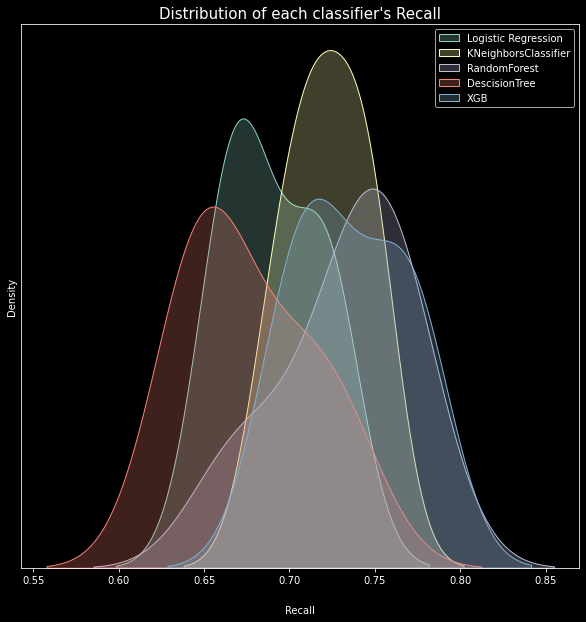

In [5]:

def train_and_score(x, y):
    # Models for training
    models = [LogisticRegression(random_state=fixed_seed), KNeighborsClassifier(), RandomForestClassifier(random_state=fixed_seed),
            DecisionTreeClassifier(random_state=fixed_seed),  XGBC(seed=fixed_seed)]

    test_score = []
    train_score = []
    roc_auc_lst = []

    # Loops through each mosel and get their score
    for model in models:
        model.fit(x_train, y_train)
        proba = model.predict_proba(x_test)[:, 1]
        test = model.score(x_test, y_test)
        train = model.score(x_train, y_train)
        roc_auc = roc_auc_score(y_test, proba)
        test_score.append(test)
        train_score.append(train)
        roc_auc_lst.append(roc_auc)
    # Score dataframe   
    models_score = {
        'Train Score': train_score,
        'Test_Score': test_score,
        "ROC_AUC Score": roc_auc_lst
    }
    df= pd.DataFrame(models_score, index=['LogisticRegression','KNeighborsClassifier', 'RandomForestClassifier', 
                                    'DecisionTreeClassifier', 'XGBC'])
    
    # Using stratified kfold to get the recall of each model
    skf = StratifiedKFold(n_splits= 5 , shuffle= True , random_state= fixed_seed ) 
    recall=[]
    for model in models:
        result = cross_val_score(model, x, y, cv=skf, scoring="recall", n_jobs=-1)
        recall.append(result)
    classifiers=['Logistic Regression', 'KNeighborsClassifier', 'RandomForest', 'DescisionTree', 'XGB']

    plt.figure(figsize=(10, 10))
    for x in range(len(recall)):
        sb.kdeplot(recall[x], shade=True)
        
    plt.title("Distribution of each classifier's Recall", fontsize=15)
    plt.legend(classifiers)
    plt.xlabel("Recall", labelpad=20)
    plt.yticks([])
    return df
    plt.show()
    
train_and_score(x, y)

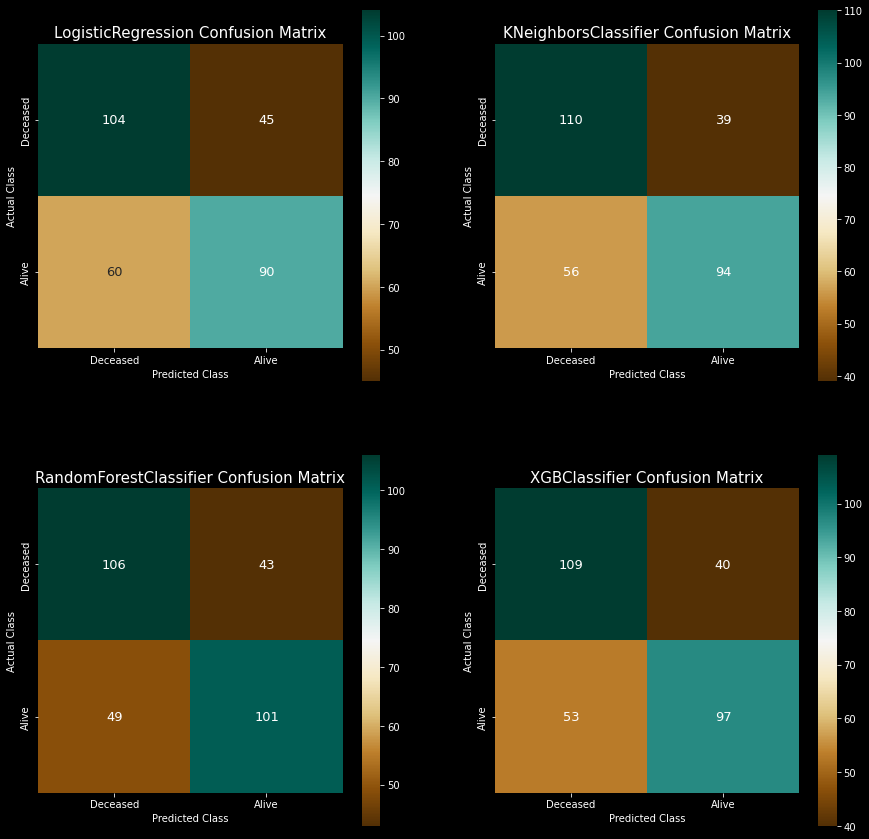

In [6]:
def model_confusion_matrix():
    # Models with AUC-ROC score > 0.7
    sub_models = [LogisticRegression(random_state=fixed_seed), KNeighborsClassifier(), RandomForestClassifier(random_state=fixed_seed), XGBC(seed=fixed_seed)]
    # Getting the confusion metric for each model 
    cm = []
    for model in sub_models:
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        model_cm = confusion_matrix(y_test, pred)
        cm.append(model_cm)
        
    # Function to plot heatmap
    def cm_heatmap(cm, ax, r, c, model):
        title = str(sub_models[model]).split('(')[0]
        ax[r,c].set_title(f"{title} Confusion Matrix", fontsize=15.)
        fig = sb.heatmap(cm, square = True, xticklabels = ["Deceased", "Alive"], annot = True, ax=ax[r,c],
                        annot_kws = {"fontsize": 13}, yticklabels = ["Deceased", "Alive"],
                        cbar = True, cbar_kws = {"orientation": "vertical"}, cmap = "BrBG", fmt='d').set(
            xlabel = "Predicted Class", ylabel = "Actual Class",)
        return fig
    
    # Displaying confusion metrics
    f, ax = plt.subplots(2, 2, figsize=(15, 15))
    cm_heatmap(cm[0], ax, 0, 0, 0)
    cm_heatmap(cm[1], ax, 0, 1, 1)
    cm_heatmap(cm[2], ax, 1, 0, 2)
    cm_heatmap(cm[3], ax, 1, 1, 3)
    plt.show()

model_confusion_matrix()

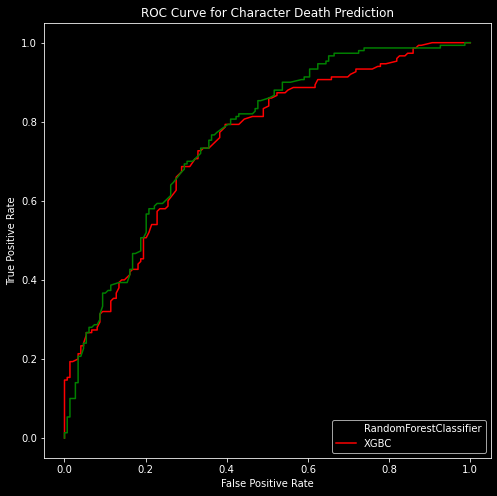

In [7]:
def model_ROC_curve():
    # Two best model based on AUC-ROC score and confusion matrix observation.
    best_model = [RandomForestClassifier(random_state=fixed_seed), XGBC(seed=fixed_seed)]
    # ROC curve for each model
    roc = []
    for model in best_model:
        model.fit(x_train, y_train)
        proba = model.predict_proba(x_test)[:, 1]
        roc_cur = roc_curve(y_test, proba)
        roc.append(roc_cur)
    
    # Plotting ROC curve for the models
    fig = plt.figure(figsize=(8, 8))
    fpr1, tpr1, thresholds1 = roc[0]
    fpr2, tpr2, thresholds2 = roc[1]

    plt.plot([0, 1], [0, 1], 'k--')

    # Plot tpr against fpr
    plt.plot(fpr1, tpr1, color='r')
    plt.plot(fpr2, tpr2, color='g')
    plt.legend(['RandomForestClassifier', 'XGBC'], loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Character Death Prediction')
    plt.show()
    
model_ROC_curve()

In [8]:
# Two best model based on AUC-ROC score and confusion matrix observation.
best_model = [RandomForestClassifier(random_state=fixed_seed), XGBC(seed=fixed_seed)]

for model in best_model:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    print(str(model).split('(')[0])
    cls_rep = classification_report(y_test, pred, target_names=['Dead', 'Alive'])
    print(cls_rep)
    print('='*40)

RandomForestClassifier
              precision    recall  f1-score   support

        Dead       0.68      0.71      0.70       149
       Alive       0.70      0.67      0.69       150

    accuracy                           0.69       299
   macro avg       0.69      0.69      0.69       299
weighted avg       0.69      0.69      0.69       299

XGBClassifier
              precision    recall  f1-score   support

        Dead       0.67      0.73      0.70       149
       Alive       0.71      0.65      0.68       150

    accuracy                           0.69       299
   macro avg       0.69      0.69      0.69       299
weighted avg       0.69      0.69      0.69       299



## Hyper Parameter Tuning 1

### Random Search with Cross Validation

In [9]:
random_grid = {'bootstrap': [True, False],
                'max_depth': [20, 40, 60, 80,],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10],
                'criterion': ["gini", "entropy"],
                'n_estimators': [200, 400, 600, 800,],
                }

In [10]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state=fixed_seed)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
                                random_state=fixed_seed, n_jobs = -1, scoring='neg_mean_absolute_error')
# Fit the random search model
rfc_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [20, 40, 60, 80],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [11]:
rfc_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'criterion': 'gini',
 'bootstrap': False}

In [12]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    print('Model Performance')
    print('='*30)
    avg_error = 'Average Error: {:0.4f} degrees.'.format(np.mean(errors))
    print(avg_error)
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy: {:0.2f}%.'.format(100 * accuracy))
    
    return [np.mean(errors), accuracy]

def improvement(new_score, base):
    print('Improvement Error: {:0.2f}%.'.format( 100 * (new_score[0] - base[0]) / base[0]))
    print('Improvement Accuracy: {:0.2f}%.'.format( 100 * (new_score[1] - base[1]) / base[1]))
    print('=' * 30)


## Evaluate Performance of the Model

In [13]:
base_model = RandomForestClassifier(n_estimators = 100, random_state = fixed_seed)
base_model.fit(x_train, y_train)
base_performance = evaluate(base_model, x_test, y_test)

Model Performance
Average Error: 0.3077 degrees.
Accuracy: 69.23%.


#### Performance of Beast Random Search Model

In [14]:
best_random = rfc_random.best_estimator_
random_performance = evaluate(best_random, x_test, y_test)
improvement(random_performance, base_performance)

Model Performance
Average Error: 0.3010 degrees.
Accuracy: 69.90%.
Improvement Error: -2.17%.
Improvement Accuracy: 0.97%.


Now let's do a grid search around the best parameter gotten from the random search

## Hyper Parameter Tuning 2

### Grid Search with Cross Validation

In [15]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [200, 400, 600],
    'criterion': ["gini"]
}
# Create a based model
rfc = RandomForestClassifier(random_state=fixed_seed)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, scoring='neg_mean_absolute_error',
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [50, 60], 'max_features': ['auto'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [200, 400, 600]},
             scoring='neg_mean_absolute_error', verbose=2)

In [16]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 200}

#### Performance of Best Model from Grid Search

In [17]:
best_grid = grid_search.best_estimator_
grid_performance = evaluate(best_grid, x_test, y_test)
improvement(grid_performance, base_performance)

Model Performance
Average Error: 0.3077 degrees.
Accuracy: 69.23%.
Improvement Error: 0.00%.
Improvement Accuracy: 0.00%.


There seem to be a hug
It seems we have about maxed out performance, but we can give it one more try with a grid further refined from our previous results. The code is the same as before just with a different grid so I only present the results:

## Hyper Parameter Tuning 3

#### Another Grid Search

In [18]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [40, 50,],
    'max_features': ['auto'],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [2, 3],
    'n_estimators': [100, 200, 300],
    'criterion': ["gini"]
}
# Create a based model
rfc = RandomForestClassifier(random_state=fixed_seed)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, scoring='neg_mean_absolute_error',
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [40, 50], 'max_features': ['auto'],
                         'min_samples_leaf': [5, 6, 7],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [19]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [20]:
best_grid = grid_search.best_estimator_
grid_performance2 = evaluate(best_grid, x_test, y_test)
improvement(grid_performance2, base_performance)

Model Performance
Average Error: 0.2910 degrees.
Accuracy: 70.90%.
Improvement Error: -5.43%.
Improvement Accuracy: 2.42%.


A big decrease in performance, that is, the error has decrease by 9.38%, yet the same best parameters was given. This indicates we have reached diminishing returns for hyperparameter tuning. We could continue, but the returns would be the same output in terms of parameters.

### Final Model 

In [21]:
final_model = grid_search.best_estimator_
print('Final Model Parameter:')
print('='*30)
print(final_model.get_params())
print('='*30)
grid_final_accuracy = evaluate(final_model, x_test, y_test)

Final Model Parameter:
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Model Performance
Average Error: 0.2910 degrees.
Accuracy: 70.90%.
